# MNIST Data Analysis

In [1]:
%%capture

import numpy as np
import matplotlib.pyplot as plt

import import_ipynb
import DataUtils as DU

import cache_magic # pip install ipython-cache

In [2]:
Ximg, Xlab = DU.load_data("data/mnist_70000.h5")

## Raw Data

MNIST is a dataset of 70,000 handwritten digit images, each normalized to fit within a 28x28 array.

Digits are written by different subjects, thus there is considerable variation in the way that digits are formed.

Here is a sample of the digits found in MNIST:

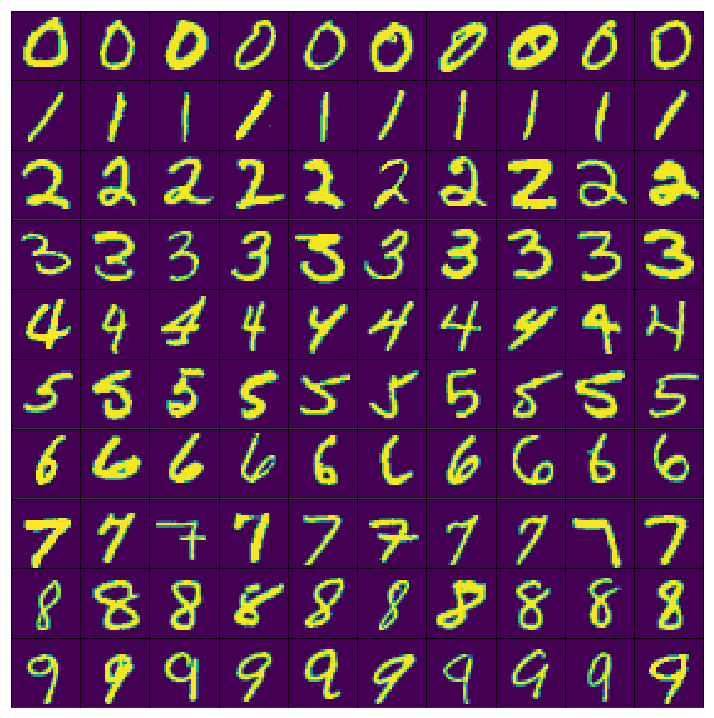

In [3]:
grouped = np.hstack([np.arange(70000)[Xlab==i][:10] for i in range(10)])
DU.show_data(Ximg[grouped], cols=10)

## Principal Components

We perform singular value decomposition of the covariance matrix to determine the principal components of the data.

### Explanation of variance

The following graph shows the relative magnitude of each principal component, and how much total variance is explained by the first $k$ principal components.


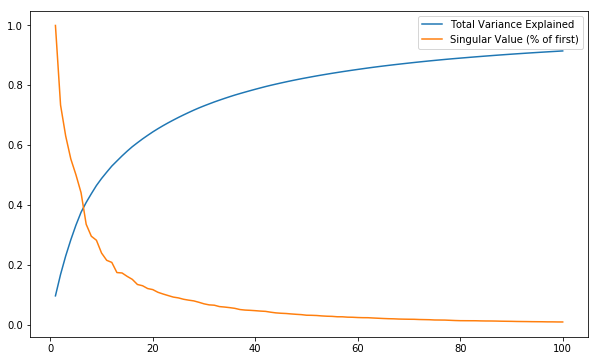

In [4]:
X, Xbar, CX = DU.normalize_image_data(Ximg)
Xu, Xs, Xvt = np.linalg.svd(CX)
DU.graph_variance_explained(Xs)

Here, we see that the first 50 principal components explain about 80% of the variance in the data.

### Visualizing the Average Image

We have preprocessed our data to be zero mean across each pixel.

This is what the average image from this dataset looks like:

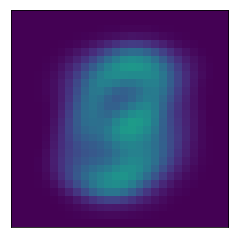

In [5]:
DU.show_img(DU.X_to_img(0, Xbar))

The average number looks vaguely like a faint, blury number (perhaps an 8 or a 3).

When we examine principle components, it is important to remember that each PC represents a direction which is "added" to this base image.  (In other words, this image represents the origin in PCA space.)


### Visualizing Principal Components

We can interpret the meaning of each principal component by projecting it as an image.

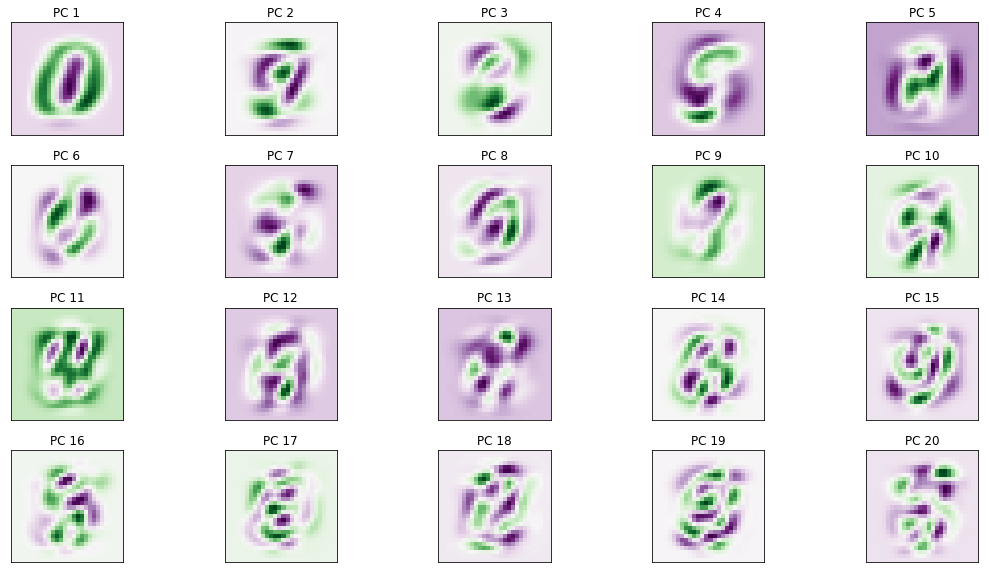

In [6]:
DU.show_pcs(Xu, 20)

The graph above shows the first 20 principal components.

* The first principal component (PC 1) differentiates between the images `0` and `1`.
* PCs 2-4 include some recognizable features of digits `9`, `3`, and `6`.
* As further principal components are visualized, the apparent complexity of their respective images increases.

### Determining the Subspace

We can attempt to visually estimate the dimension of the linear subspace for MNIST data by looking at dimensionally reduced images projected back into pixel space.

Here, we examine the quality of 20 random digits as they are projected into truncated PCA coordianates.

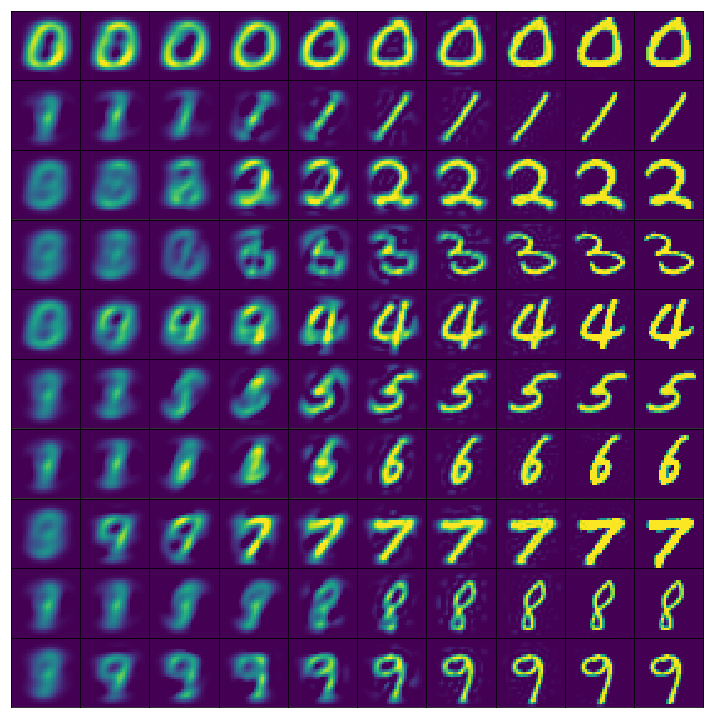

In [7]:
dims = [1, 2, 5, 10, 20, 50, 100, 200, 400, 784]

samp = X[:20]
Psamp = [(X[grouped][0:100:10,:] @ Xu[:,:k]) @ Xu.T[:k,:] for k in dims]

pcadigits = np.asarray(Psamp).transpose((1,0,2))

DU.show_data(DU.X_to_img(np.vstack(pcadigits), Xbar), cols=10)

In the image above, each row represents an original data point, and each column represents a level of PCA dimension reduction.





### Observations

We can characterize the number of components used roughly as follows:

| Dimension | % Variance | Description                                   |
| --------- | ---------- | --------------------------------------------- |
| 1         | 10%        | digits appear as `0`-like or `1`-like         |
| 2         | 15%        | digits appear as `0`, `1`, `3`, or `9`-like   |
| 5         | 25%        | rough shapes for `7` and `8` begin to emerge  |
| 10        | 40%        | basic forms become recognizable               |
| 20        | 60%        | most digits are recognizable                  |
| 50        | 80%        | all digits are easily recognizable            |
| 100       | 90%        | edges sharpen; background artifacts are reduced |
| 200       | 95%        | digits appear sharp; small background artifacts remain |
| 400       | 99%        | background artifacts can no longer be seen    |
| 784       | 100%       | original images are perfectly restored        |          


## Embeddings

### PCA

We can look at the relationships between the most significant prinipal components by creating a scatterplot matrix.

Here, we show a scatterplot matrix of PC 1-5, with histograms on the diagonal.

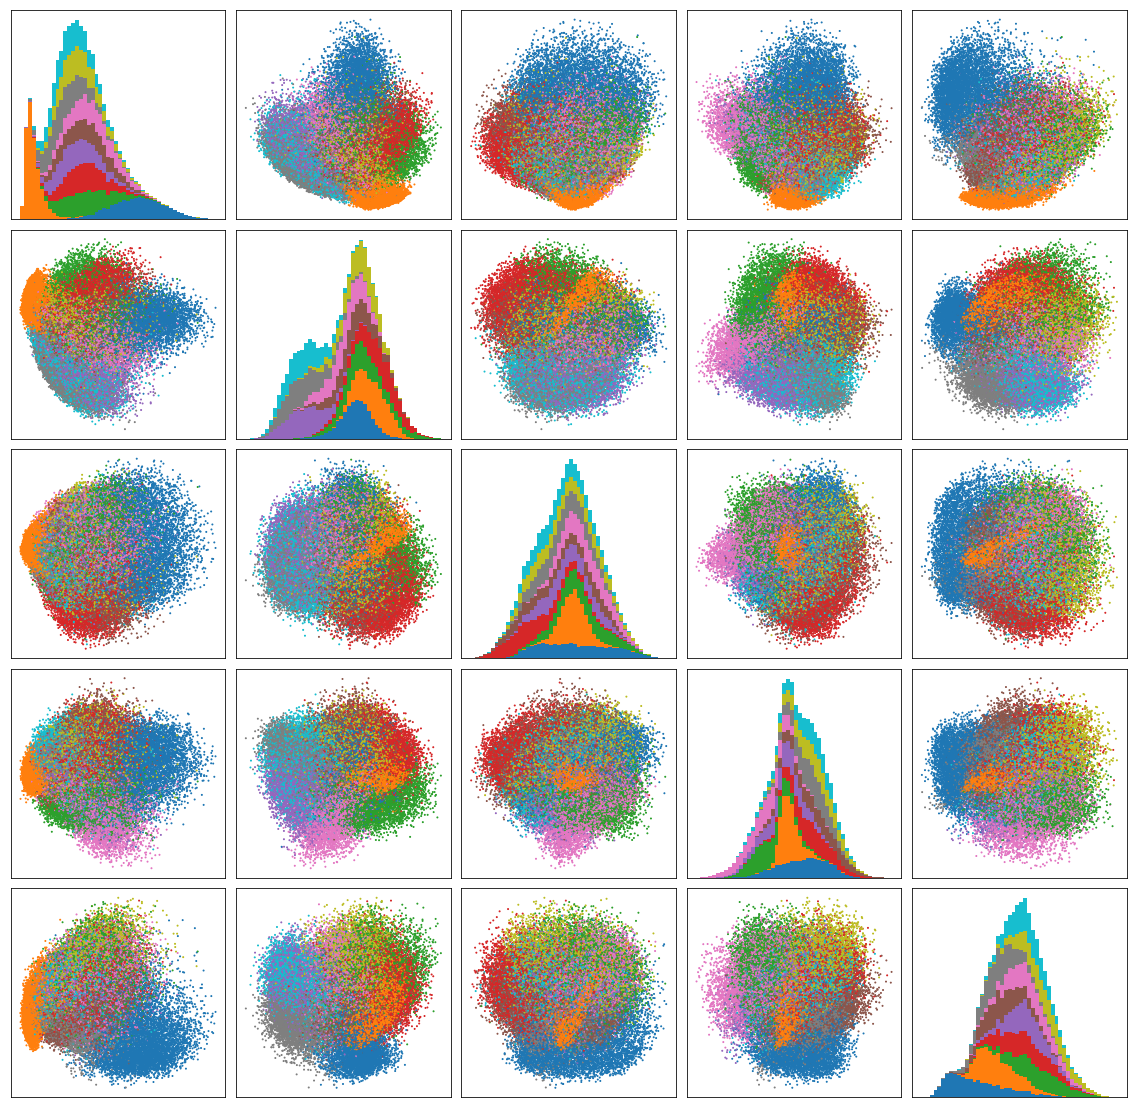

In [8]:
DU.show_splom(X @ Xu[:,:5], labels=Xlab, width=20)

Note:

* PC 1 alone is able to differentiate between the digits 0-1 almost perfectly.
* PCs 2-5 show some correlation with certain digit categories, however none of these PCs seem to provide an obvious means for separating other digits (taken individually or pairwise).

### Isomap

We compare the Isomap embeddings of the data when projected into the first $k$ principal components.

Due to slow runtimes for Isomap on large datasets, we limit the number of points to `20,000`.

In [9]:
nsamp = 20000
Xsamp = X[:nsamp]

In [10]:
%cache isomap_mnist_pca5 = DU.isomap_embedding(Xsamp @ Xu[:,:5])
%cache isomap_mnist_pca10 = DU.isomap_embedding(Xsamp @ Xu[:,:10])
%cache isomap_mnist_pca20 = DU.isomap_embedding(Xsamp @ Xu[:,:20])
%cache isomap_mnist_pca50 = DU.isomap_embedding(Xsamp @ Xu[:,:50])
%cache isomap_mnist_pca100 = DU.isomap_embedding(Xsamp @ Xu[:,:100])
%cache isomap_mnist_all = DU.isomap_embedding(Xsamp)

loading cached value for variable 'isomap_mnist_pca5'. Time since pickling  1 day, 22:17:46.702601
loading cached value for variable 'isomap_mnist_pca10'. Time since pickling  1 day, 22:11:33.560750
loading cached value for variable 'isomap_mnist_pca20'. Time since pickling  1 day, 22:05:06.784743
loading cached value for variable 'isomap_mnist_pca50'. Time since pickling  1 day, 21:57:57.973252
loading cached value for variable 'isomap_mnist_pca100'. Time since pickling  1 day, 21:50:09.806316
loading cached value for variable 'isomap_mnist_all'. Time since pickling  1 day, 21:36:17.394662


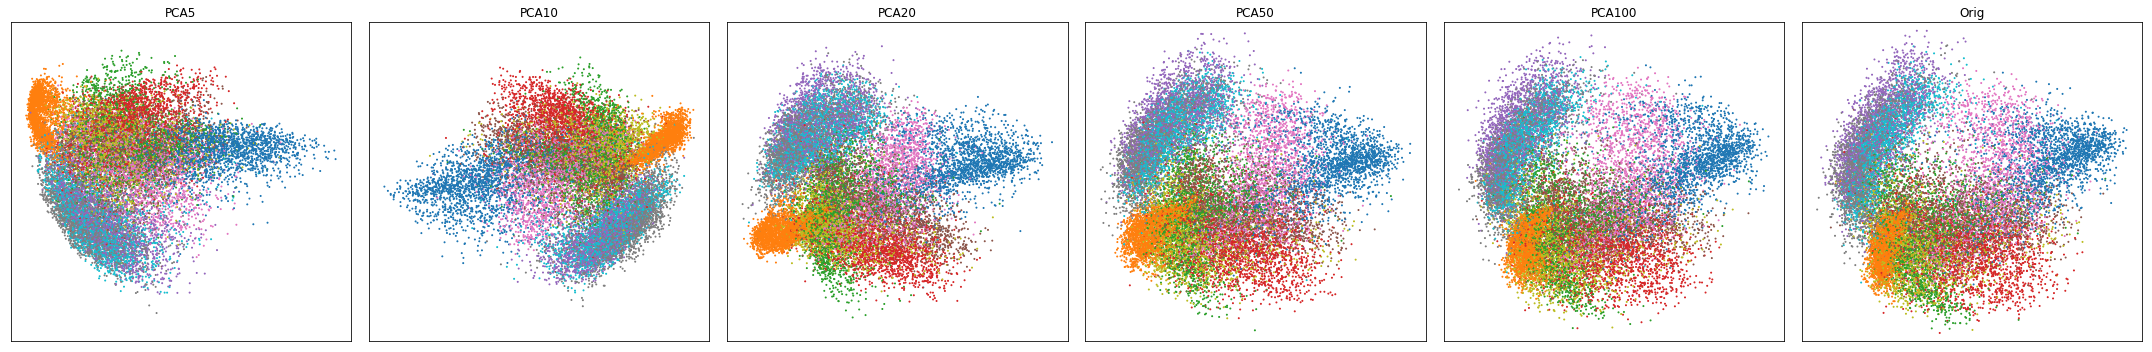

In [11]:
DU.show_embeddings(
    [isomap_mnist_pca5, isomap_mnist_pca10, isomap_mnist_pca20, isomap_mnist_pca50, isomap_mnist_pca100, isomap_mnist_all],
    titles=["PCA5", "PCA10", "PCA20", "PCA50", "PCA100", "Orig"],
    labels=Xlab[:nsamp]
)

There is little variation across the images provided.  This, combined with the large clouds of overlapping points, suggests that Isomap is not capable representing the manifold in a way which clusters the MNIST digits.

### Modified Locally Linear (Modified LLE)

Next, we look at PCA projections of the data using LLE.

As with Isomap, we will restrict the data to `20,000` samples to reduce runtime.

In [12]:
%cache mlle_mnist_pca5 = DU.mlle_embedding(Xsamp @ Xu[:,:5])
%cache mlle_mnist_pca10 = DU.mlle_embedding(Xsamp @ Xu[:,:10])
%cache mlle_mnist_pca20 = DU.mlle_embedding(Xsamp @ Xu[:,:20])
%cache mlle_mnist_pca50 = DU.mlle_embedding(Xsamp @ Xu[:,:50])
%cache mlle_mnist_pca100 = DU.mlle_embedding(Xsamp @ Xu[:,:100])
%cache mlle_mnist_all = DU.mlle_embedding(Xsamp)

loading cached value for variable 'mlle_mnist_pca5'. Time since pickling  1 day, 21:05:09.986698
loading cached value for variable 'mlle_mnist_pca10'. Time since pickling  1 day, 20:59:12.965475
loading cached value for variable 'mlle_mnist_pca20'. Time since pickling  1 day, 20:53:46.545823
loading cached value for variable 'mlle_mnist_pca50'. Time since pickling  1 day, 20:46:46.110075
loading cached value for variable 'mlle_mnist_pca100'. Time since pickling  1 day, 20:38:44.167926
loading cached value for variable 'mlle_mnist_all'. Time since pickling  1 day, 20:23:32.287654


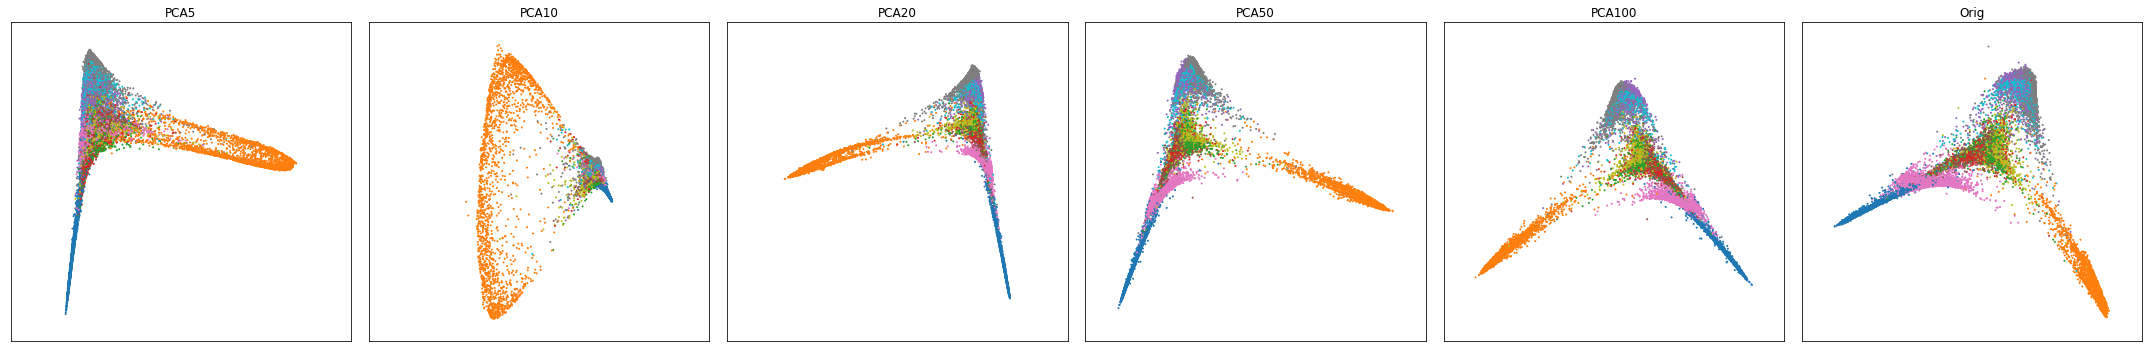

In [13]:
DU.show_embeddings(
    [mlle_mnist_pca5, mlle_mnist_pca10, mlle_mnist_pca20, mlle_mnist_pca50, mlle_mnist_pca100, mlle_mnist_all],
    titles=["PCA5", "PCA10", "PCA20", "PCA50", "PCA100", "Orig"],
    labels=Xlab[:nsamp]
)

Modified LLE produces similar embeddings when using 20 or more dimensions.  Although the shape of the embedding is crowded, and does not make efficient use of screen real estate, we can see that several of the MNIST digits are organized into separate areas, with some shared boundaries and overlap.

### Student-T Stochastic Neighbor (t-SNE)



In [14]:
%cache tsne_mnist_pca5 = DU.tsne_embedding(X @ Xu[:,:5])
%cache tsne_mnist_pca10 = DU.tsne_embedding(X @ Xu[:,:10])
%cache tsne_mnist_pca20 = DU.tsne_embedding(X @ Xu[:,:20])
%cache tsne_mnist_pca50 = DU.tsne_embedding(X @ Xu[:,:50])
%cache tsne_mnist_pca100 = DU.tsne_embedding(X @ Xu[:,:100])
%cache tsne_mnist_all = DU.tsne_embedding(X)

loading cached value for variable 'tsne_mnist_pca5'. Time since pickling  1 day, 15:11:55.194068
loading cached value for variable 'tsne_mnist_pca10'. Time since pickling  1 day, 14:56:36.730745
loading cached value for variable 'tsne_mnist_pca20'. Time since pickling  1 day, 14:39:55.935736
loading cached value for variable 'tsne_mnist_pca50'. Time since pickling  1 day, 14:19:19.266739
loading cached value for variable 'tsne_mnist_pca100'. Time since pickling  1 day, 13:52:20.366601
loading cached value for variable 'tsne_mnist_all'. Time since pickling  1 day, 12:15:36.462132


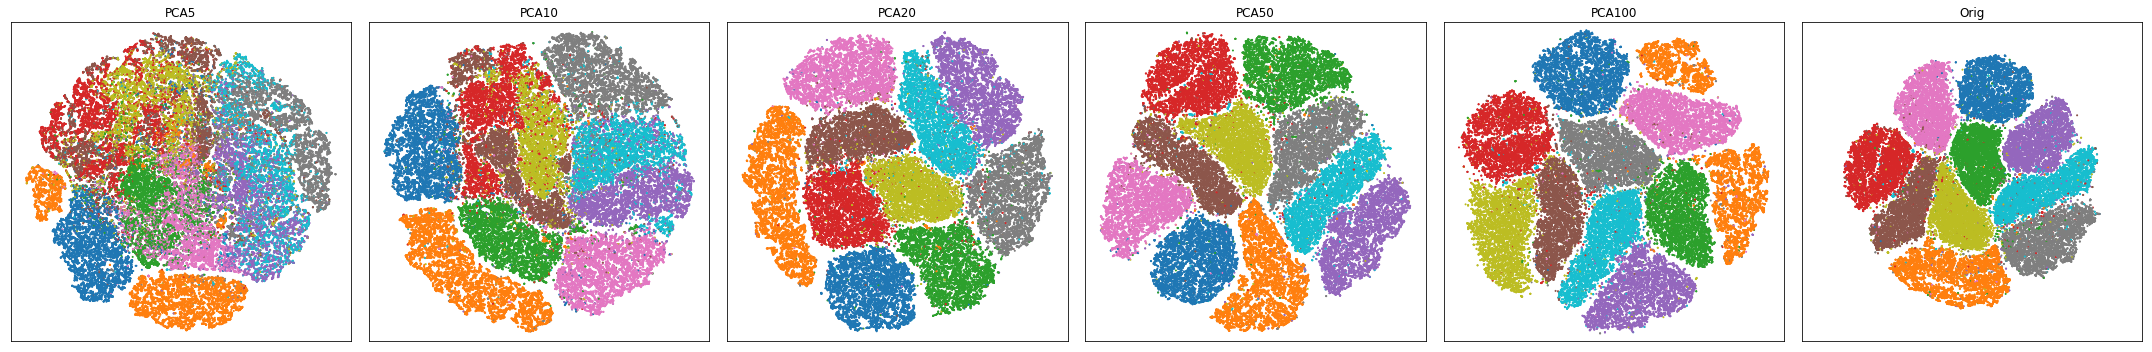

In [15]:
DU.show_embeddings(
    [tsne_mnist_pca5, tsne_mnist_pca10, tsne_mnist_pca20, tsne_mnist_pca50, tsne_mnist_pca100, tsne_mnist_all],
    titles=["PCA5", "PCA10", "PCA20", "PCA50", "PCA100", "Orig"],
    labels=Xlab
)

The t-SNE embeddings show clear improvement through 5, 10, and 20 PCA dimensions.  At 50 dimensions we see distinct clusters for all 10 digits, with fairly good separation between clusters.  Additional dimensions offer no discernable improvement.

### Uniform Manifold Approximation and Projection (UMAP)

Here, we look at same PCA projections of the data using UMAP.

In [16]:
%cache umap_mnist_pca5 = DU.umap_embedding(X @ Xu[:,:5])
%cache umap_mnist_pca10 = DU.umap_embedding(X @ Xu[:,:10])
%cache umap_mnist_pca20 = DU.umap_embedding(X @ Xu[:,:20])
%cache umap_mnist_pca50 = DU.umap_embedding(X @ Xu[:,:50])
%cache umap_mnist_pca100 = DU.umap_embedding(X @ Xu[:,:100])
%cache umap_mnist_all = DU.umap_embedding(X)

loading cached value for variable 'umap_mnist_pca5'. Time since pickling  1 day, 22:58:17.388035
loading cached value for variable 'umap_mnist_pca10'. Time since pickling  1 day, 22:57:13.156182
loading cached value for variable 'umap_mnist_pca20'. Time since pickling  1 day, 22:56:07.409829
loading cached value for variable 'umap_mnist_pca50'. Time since pickling  1 day, 22:55:00.267690
loading cached value for variable 'umap_mnist_pca100'. Time since pickling  1 day, 22:53:51.632950
loading cached value for variable 'umap_mnist_all'. Time since pickling  1 day, 22:52:32.675153


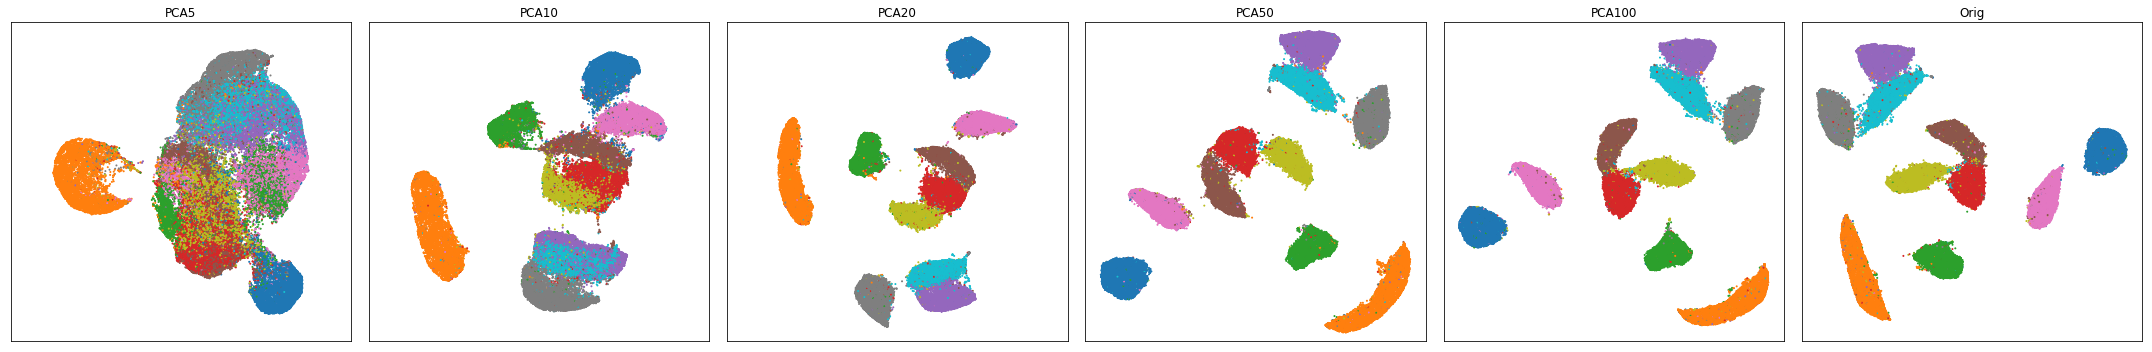

In [17]:
DU.show_embeddings(
    [umap_mnist_pca5, umap_mnist_pca10, umap_mnist_pca20, umap_mnist_pca50, umap_mnist_pca100, umap_mnist_all],
    titles=["PCA5", "PCA10", "PCA20", "PCA50", "PCA100", "Orig"],
    labels=Xlab
)

The UMAP embeddings appear to do the best job of representing the manifold in two dimensions.  Based on the compactness and separation of visible clusters, UMAP validates our earlier understanding of the manifold and subspace.

## Conclusion: Manifold lies in 50-D Subspace

MNIST data lies on a manifold which is able to reveal clusters for each of the separate digits.  When the data is projected into the subspace of the first 50 principal components, this manifold is largely preserved, with no discernable loss in the ability to differentiate digits.

In [18]:
%cache